In [ ]:
import os
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms, models
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from fpdf import FPDF
import cv2

# =============================
# CONFIG
# =============================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 4
CLASS_NAMES = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
COLOR_MAP = {
    'EOSINOPHIL': (255, 0, 0),
    'LYMPHOCYTE': (0, 255, 0),
    'MONOCYTE': (0, 0, 255),
    'NEUTROPHIL': (255, 255, 0)
}

# =============================
# TRANSFORM
# =============================
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# =============================
# LOAD MODELS
# =============================
def load_models():
    # Segmentação
    seg_model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=3,
        classes=1
    ).to(DEVICE)
    seg_model.load_state_dict(torch.load("../models/best_segmentation_model.pth", map_location=DEVICE))
    seg_model.eval()

    # Classificação
    clf_model = models.resnet50(pretrained=False)
    clf_model.fc = torch.nn.Linear(clf_model.fc.in_features, NUM_CLASSES)
    clf_model.load_state_dict(torch.load("../models/best_classification_model.pth", map_location=DEVICE))
    clf_model = clf_model.to(DEVICE)
    clf_model.eval()

    return seg_model, clf_model

# =============================
# PREDICT FUNCTION
# =============================
def predict(image_path, seg_model, clf_model):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Segmentação
    with torch.no_grad():
        mask = seg_model(input_tensor)
        mask = torch.sigmoid(mask).squeeze().cpu().numpy()
        binary_mask = (mask > 0.5).astype(np.uint8)

    # Contornos
    orig_image = np.array(image.resize(IMAGE_SIZE))
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Classificação por célula (crops)
    cell_counts = {cls: 0 for cls in CLASS_NAMES}
    image_with_boxes = orig_image.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < 10 or h < 10:
            continue  

        crop = orig_image[y:y+h, x:x+w]
        crop_pil = Image.fromarray(crop).resize(IMAGE_SIZE)
        crop_tensor = transform(crop_pil).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits = clf_model(crop_tensor)
            pred_class = torch.argmax(logits, dim=1).item()
            class_name = CLASS_NAMES[pred_class]
            cell_counts[class_name] += 1

            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), COLOR_MAP[class_name], 2)
            cv2.putText(image_with_boxes, class_name, (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLOR_MAP[class_name], 1)

    return image_with_boxes, cell_counts

# =============================
# RELATÓRIO AUTOMÁTICO
# =============================
def gerar_diagnostico(cell_counts):
    total = sum(cell_counts.values())
    if total == 0:
        return "Nenhuma célula foi identificada na amostra analisada. Reavaliar a preparação da lâmina ou considerar nova coleta."

    porcentagens = {cls: (cell_counts[cls] / total) * 100 for cls in CLASS_NAMES}
    laudo = "Laudo Hematológico Automatizado\n\n"
    laudo += "Quantificação celular observada na amostra:\n"
    for cls in CLASS_NAMES:
        laudo += f"- {cls.capitalize()}: {cell_counts[cls]} células ({porcentagens[cls]:.2f}%)\n"
    laudo += "\n"

    achados = []

    total_leucocitos = sum(cell_counts.values())

    # Leucocitose / Leucopenia
    if total_leucocitos > 100:
        achados.append("Leucocitose relativa — aumento do número total de leucócitos.")
    elif 0 < total_leucocitos < 20:
        achados.append("Leucopenia relativa — redução do número total de leucócitos.")

    # Possível esferocitose (sinal indireto)
    if cell_counts['MONOCYTE'] > 30 and cell_counts['EOSINOPHIL'] > 30:
        achados.append("Presença aumentada de monócitos e eosinófilos. Considerar investigação para esferocitose hereditária.")

    # Possível anemia
    if cell_counts['NEUTROPHIL'] < 5 and total > 0:
        achados.append("Contagem reduzida de neutrófilos. Sugerida triagem para distúrbios anêmicos ou imunossupressão.")

    # Conclusão
    if not achados:
        laudo += "Interpretação: Não foram observadas alterações morfológicas ou quantitativas relevantes nas populações leucocitárias.\n"
    else:
        laudo += "Achados relevantes:\n"
        for item in achados:
            laudo += f"- {item}\n"

    # Recomendação clínica
    if any(word in laudo for word in ["Leucocitose", "Leucopenia"]):
        laudo += "\nRecomendação: Os achados sugerem alteração no perfil leucocitário. Recomenda-se correlação clínica e, se necessário, exames complementares.\n"

    return laudo

def salvar_pdf(texto, path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    for linha in texto.split('\n'):
        pdf.multi_cell(0, 10, linha)
    pdf.output(path)

input_dir = "../notebooks/input"
output_dir = "../notebooks/output"
os.makedirs(output_dir, exist_ok=True)

seg_model, clf_model = load_models()

contagem_total = {cls: 0 for cls in CLASS_NAMES}
imagens_relevantes = []

for filename in os.listdir(input_dir):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        continue

    image_path = os.path.join(input_dir, filename)
    try:
        img_com_celulas, contagem = predict(image_path, seg_model, clf_model)

        for cls in CLASS_NAMES:
            contagem_total[cls] += contagem[cls]

        if any([
            contagem['MONOCYTE'] > 30 and contagem['EOSINOPHIL'] > 30,  # Esferocitose
            contagem['NEUTROPHIL'] < 5 and sum(contagem.values()) > 0,  # Anemia
            sum(contagem.values()) > 100 or (0 < sum(contagem.values()) < 20)  # Leucocitose / leucopenia
        ]):
            imagens_relevantes.append((filename, img_com_celulas))

    except Exception as e:
        print(f"Erro ao processar {filename}: {e}")

laudo_final = gerar_diagnostico(contagem_total)

salvar_pdf(laudo_final, os.path.join(output_dir, "laudo_final.pdf"))
with open(os.path.join(output_dir, "laudo_final.txt"), 'w') as f:
    f.write(laudo_final)

for nome_arquivo, imagem in imagens_relevantes:
    base_filename = os.path.splitext(nome_arquivo)[0]
    output_img_path = os.path.join(output_dir, f"{base_filename}_relevante.png")
    cv2.imwrite(output_img_path, cv2.cvtColor(imagem, cv2.COLOR_RGB2BGR))


d:\Estudos\Artificial-Inteligence\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Estudos\Artificial-Inteligence\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🧪 Modelos carregados com sucesso.
🔍 Processando imagem: BloodImage_00077.jpg
🔍 Processando imagem: BloodImage_00078.jpg
🔍 Processando imagem: BloodImage_00079.jpg
🔍 Processando imagem: BloodImage_00081.jpg
🔍 Processando imagem: BloodImage_00082.jpg
🔍 Processando imagem: BloodImage_00083.jpg
🔍 Processando imagem: BloodImage_00086.jpg
🔍 Processando imagem: BloodImage_00087.jpg
🔍 Processando imagem: BloodImage_00088.jpg
🔍 Processando imagem: BloodImage_00089.jpg
🔍 Processando imagem: BloodImage_00090.jpg
🔍 Processando imagem: BloodImage_00091.jpg
🔍 Processando imagem: BloodImage_00092.jpg
🔍 Processando imagem: BloodImage_00093.jpg
🔍 Processando imagem: BloodImage_00094.jpg
🔍 Processando imagem: BloodImage_00095.jpg
🔍 Processando imagem: BloodImage_00096.jpg
🔍 Processando imagem: BloodImage_00097.jpg
🔍 Processando imagem: BloodImage_00098.jpg
🔍 Processando imagem: BloodImage_00099.jpg
🔍 Processando imagem: BloodImage_00100.jpg
🔍 Processando imagem: BloodImage_00101.jpg
🔍 Processando imagem


=== Testando modelo com backbone pré-treinado: False e normalização: normalização_05 ===
Pesos personalizados carregados com sucesso!
Testando com imagem real:
Output stats - min: 0.0000, max: 0.0721, mean: 0.0207


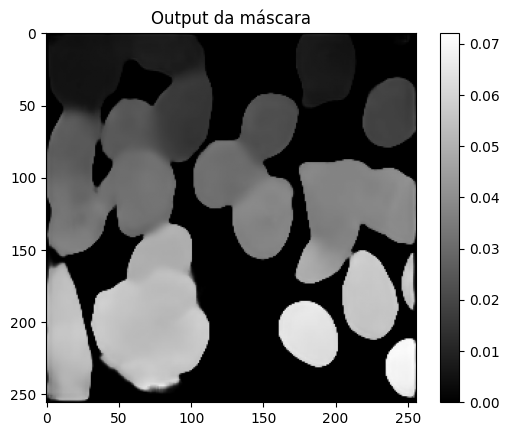

Testando com imagem dummy:
Output stats - min: 0.0000, max: 0.0002, mean: 0.0000


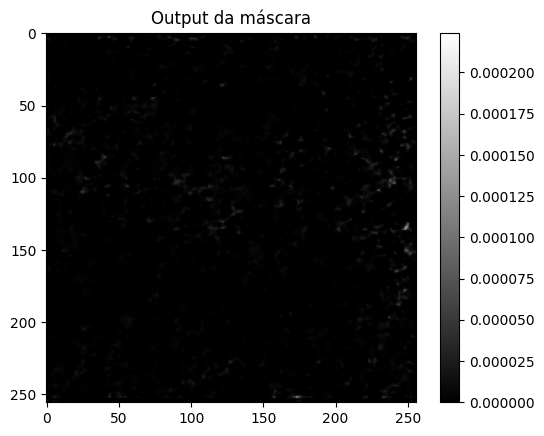


=== Testando modelo com backbone pré-treinado: False e normalização: normalização_imagenet ===
Pesos personalizados carregados com sucesso!
Testando com imagem real:
Output stats - min: 0.0000, max: 0.0775, mean: 0.0128


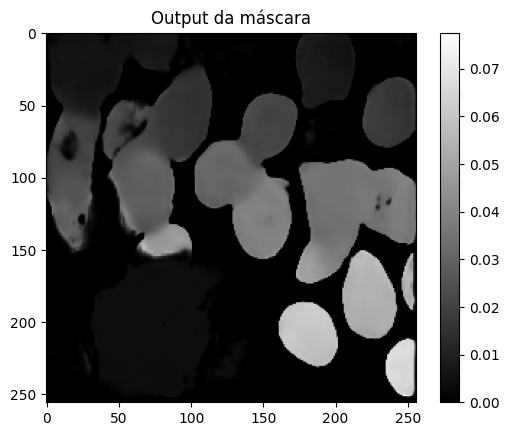

Testando com imagem dummy:
Output stats - min: 0.0000, max: 0.0006, mean: 0.0000


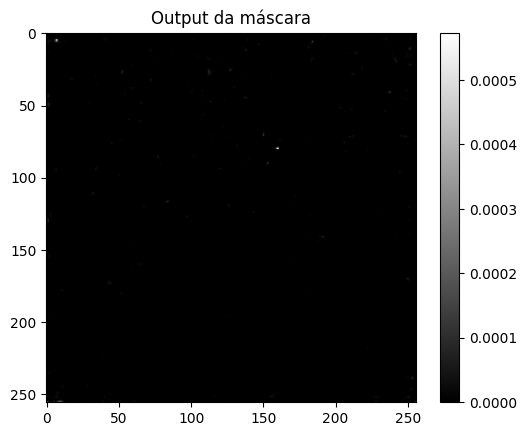


=== Testando modelo com backbone pré-treinado: True e normalização: normalização_05 ===
Testando com imagem real:
Output stats - min: 0.1939, max: 0.5170, mean: 0.3874


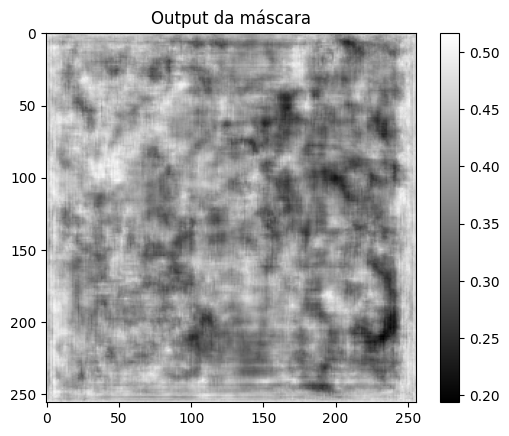

Testando com imagem dummy:
Output stats - min: 0.2107, max: 0.5313, mean: 0.3788


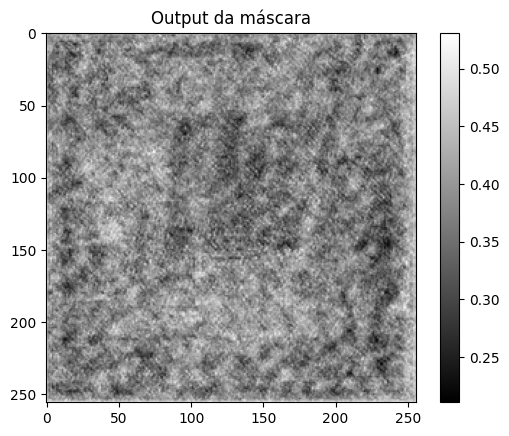


=== Testando modelo com backbone pré-treinado: True e normalização: normalização_imagenet ===
Testando com imagem real:
Output stats - min: 0.3513, max: 0.6170, mean: 0.4845


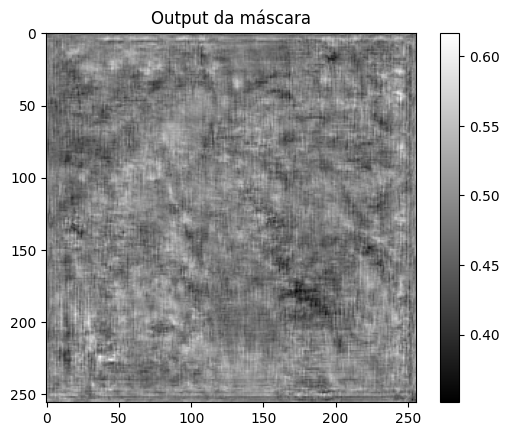

Testando com imagem dummy:
Output stats - min: 0.2426, max: 0.7485, mean: 0.4909


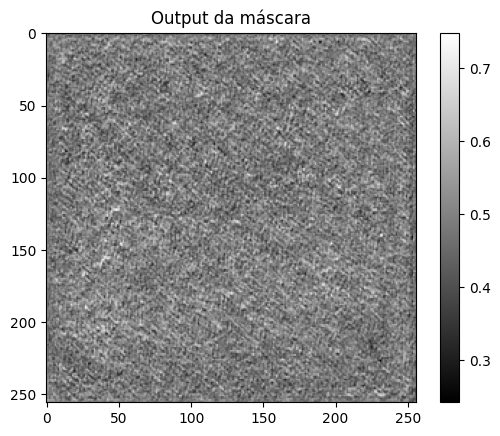

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import segmentation_models_pytorch as smp

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (256, 256)

norms = {
    "normalização_05": transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    "normalização_imagenet": transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
}

def get_transform(norm):
    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        norm
    ])

def load_model(pretrained_backbone):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet" if pretrained_backbone else None,
        in_channels=3,
        classes=1
    ).to(DEVICE)
    if not pretrained_backbone:
        try:
            model.load_state_dict(torch.load("../models/best_segmentation_model.pth", map_location=DEVICE))
            print("Pesos personalizados carregados com sucesso!")
        except Exception as e:
            print(f"Erro carregando pesos personalizados: {e}")
    model.eval()
    return model

def test_model_output(model, transform, image_path=None):
    if image_path:
        img = Image.open(image_path).convert('RGB')
    else:
        img = Image.fromarray(np.uint8(np.random.rand(*IMAGE_SIZE, 3)*255))

    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    print(f"Output stats - min: {output.min():.4f}, max: {output.max():.4f}, mean: {output.mean():.4f}")
    plt.imshow(output, cmap='gray')
    plt.title("Output da máscara")
    plt.colorbar()
    plt.show()

test_image_path = "../notebooks/input/BloodImage_00141.jpg"

for pretrained in [False, True]:
    for norm_name, norm in norms.items():
        print(f"\n=== Testando modelo com backbone pré-treinado: {pretrained} e normalização: {norm_name} ===")
        model = load_model(pretrained_backbone=pretrained)
        transform = get_transform(norm)
        print("Testando com imagem real:")
        test_model_output(model, transform, image_path=test_image_path)
        print("Testando com imagem dummy:")
        test_model_output(model, transform, image_path=None)
